In [1]:
library(tidyverse)
library(gridExtra)
library(ggExtra)
library(scales)
library(grid)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



In [2]:
`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

In [ ]:
full_features <- read_tsv('../../data/task3/4.data/ppi.tsv.xz')
features_df <- read_csv('prediction_features.csv.xz')

Parsed with column specification:
cols(
  id_a = col_double(),
  id_b = col_double(),
  network = col_character(),
  edge = col_double(),
  edge_prior = col_double(),
  rwr = col_double(),
  mean_rwr = col_double(),
  p_rwr = col_double(),
  jaccard = col_double(),
  mean_jaccard = col_double(),
  p_jaccard = col_double()
)


In [ ]:
head(features_df)

In [ ]:
head(full_features)

In [6]:
source <- full_features %>%
    filter(network == 'test_recon') %>%
    select(id_a, edge) %>%
    group_by(id_a) %>%
    summarise(degree = sum(edge))

target <- full_features %>%
    filter(network == 'test_recon') %>%
    select(id_b, edge) %>%
    group_by(id_b) %>%
    summarise(degree = sum(edge))

id_to_degree <- source %>%
    full_join(target, by = c('id_a' = 'id_b')) %>%
    mutate(degree = degree.x + degree.y) %>%
    rename(id = id_a) %>%
    select(id, degree)

head(id_to_degree, 2)

id,degree
0,75
1,3


In [7]:
df <- full_features %>%
    filter(network == 'test_recon') %>%
    left_join(
        features_df %>%
            select(-source, -target), 
        by = c("id_a", "id_b")
    ) %>%
    select(-network) %>%
    left_join(id_to_degree, by = c("id_a" = "id")) %>%
    left_join(id_to_degree, by = c("id_b" = "id")) %>%
    rename(source = degree.x, target = degree.y)

head(df, 2)

id_a,id_b,edge,edge_prior,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard,adamic_adar_index,preferential_attachment,resource_allocation_index,source,target
0,0,0,0,2.511017e-01,2.508656e-01,0.024,1,1.000000000,1,NA,NA,NA,75,75
0,1,0,0,1.296615e-05,1.110304e-05,0.089,0,0.001182502,1,0,225,0,75,3


In [8]:
vis_df <- df %>%
    filter(edge == 0 & id_a != id_b) %>%
    sample_n(500000) %>%
    mutate(
        degree_product = source * target
    ) %>%
    gather(key = 'feature', value = 'feature_value', edge_prior:resource_allocation_index) %>%
    gather(key = 'degree_side', value = 'degree', source, target, geo_mean_degree, ari_mean_degree) %>%
    mutate(
        degree_side = (
            degree_side %>% 
                recode_factor(source = 'source degree', target = 'target degree',
                              geo_mean_degree = 'geometric mean degree', 
                              ari_mean_degree = 'arithmetic mean degree',)
        ),
        edge_exists = edge %>% recode_factor(`0` = 'no unbiased edge', `1` = 'unbiased edge')
    ) %>%
    select(-starts_with('name')) %>%
    filter(!grepl('mean_|p_', feature) & feature != 'jaccard_coefficient')  %>%
    mutate(feature = feature %>%
                       recode_factor(
                           edge_prior = 'Edge prior',
                           adamic_adar_index = 'Adamic/Adar index',
                           jaccard = 'Jaccard index',
                           preferential_attachment = 'Preferential attachment',
                           resource_allocation_index = 'Resource allocation index',
                           rwr = 'RWR'
                       )
    )

head(vis_df, 2)

id_a,id_b,edge,feature,feature_value,degree_side,degree,edge_exists
253,805,0,Edge prior,0.115,source degree,244,no unbiased edge
473,3661,0,Edge prior,0.016,source degree,167,no unbiased edge


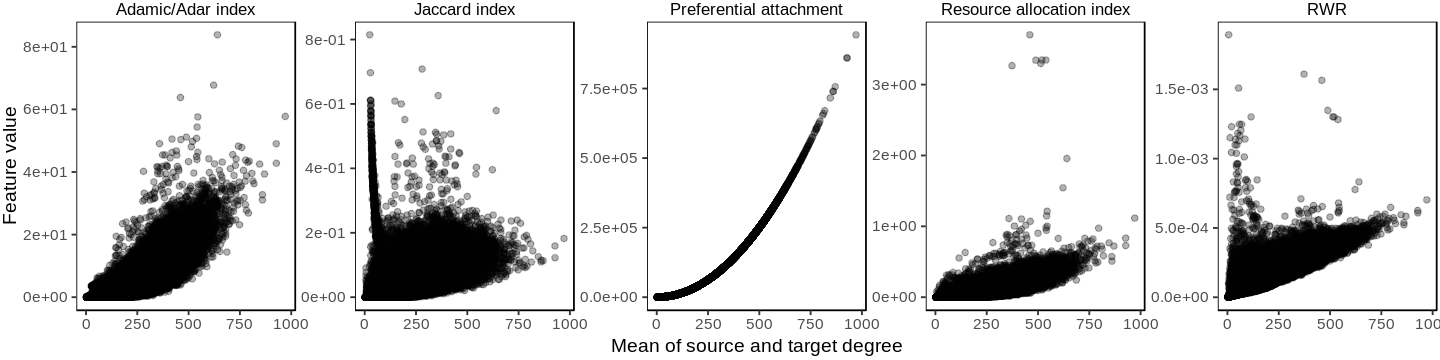

In [9]:
options(repr.plot.width=12, repr.plot.height=3)

scatter_horizontal <- (
    ggplot(vis_df %>% filter(degree_side == 'geometric mean degree' & feature != 'Edge prior'), 
           aes(x = degree, y = feature_value))
    + geom_point(alpha=0.3)
    + facet_wrap(vars(feature), scales='free', nrow = 1)
    + xlab('Mean of source and target degree')
    + ylab('Feature value')
    + scale_y_continuous(labels=scientific)
    + theme_zietzm()
)
scatter_horizontal

ggsave(filename = '../../img/fig2.feature_degree.png', 
       plot = scatter_horizontal, dpi=500, height=3, width=12)